In [1]:
import tensorflow as tf
from tensorflow.keras import models ,layers
#import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,Dropout,BatchNormalization,Activation
#from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,recall_score,precision_score,f1_score
#import sys
#import scipy.io
#import scipy.misc
#import matplotlib.pyplot as plt
#from matplotlib.pyplot import imshow
import numpy as np

In [2]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "animal_class",
    shuffle=True,
    image_size=(264,264),
    batch_size=32,
)

Found 20084 files belonging to 8 classes.


In [3]:
class_names=dataset.class_names
class_names

['butterfly', 'cow', 'dog', 'elephant', 'goat', 'hen', 'horse', 'spyder']

In [4]:
len(dataset)

628

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 264, 264, 3)
[5 7 7 5 0 4 7 0 1 1 5 1 2 0 1 5 0 7 1 0 6 7 5 5 3 0 6 0 0 1 6 5]


In [6]:
train_size=0.8
l=int(len(dataset)*train_size)
l

502

In [7]:
train_ds=dataset.take(l)
len(train_ds)

502

In [8]:
val_size=len(dataset)*0.1

In [9]:
val_size

62.800000000000004

In [10]:
val_ds=dataset.skip(l).take(62)
len(val_ds)

62

In [11]:
test_ds=dataset.skip(l).skip(62)

In [12]:
len(test_ds)

64

In [13]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [14]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [15]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

IMAGE_SIZE=264

In [16]:
resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.RandomRotation(0.2)
])
data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),

])

In [17]:
CHANNELS=3
import os
batch_size=32
input_shape=(batch_size,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes=8
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes , activation = 'softmax')
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 264, 264, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 264, 264, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 262, 262, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 131, 131, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 129, 129, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 64, 64, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 62, 62, 64)         

In [180]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    

)

In [181]:
EPOCHS=100

In [182]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,131,131] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_2/max_pooling2d/MaxPool (defined at \AppData\Local\Temp\ipykernel_46476\3314003787.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_224964]

Function call stack:
train_function


In [103]:
scores=model.evaluate(test_ds)
scores

64/64 [==============================] - 8s 117ms/step - loss: 0.7528 - accuracy: 0.7559


[0.7528241872787476, 0.755859375]

In [104]:
accuracy=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [105]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array=tf.expand_dims(img_array,0)
    
    predictions= model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class ,confidence

In [106]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [157]:
for img,label in test_ds.take(1):
    firstimg=img[0].numpy().astype('uint8')
    firstlabel=label[5].numpy()
    print("al:" , class_names[firstlabel])
    batch_pred =model.predict(img)
    print("pred label: " ,class_names[np.argmax(batch_pred[5])])

al: spyder


ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,131,131] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_2/max_pooling2d/MaxPool (defined at \AppData\Local\Temp\ipykernel_46476\1151319293.py:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_64154]

Function call stack:
predict_function


(147, 343, 3)
(1, 147, 343, 3)


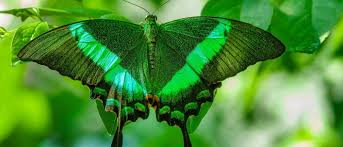

In [174]:
import numpy as np
from PIL import Image
import PIL.Image as image
s=Image.open("124.jpeg")
style_image = np.array(s)
print(style_image.shape)
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
#img_batch=np.expand_dims(style_image,0)
#print(img_batch.shape)
print(style_image.shape)
style_image
s

In [175]:
p=model.predict(style_image)

In [176]:
class_names[np.argmax(p)]


'spyder'

In [177]:
p

array([[2.6747715e-01, 1.1258088e-05, 1.3561863e-04, 2.9784885e-06,
        1.6457657e-04, 1.0702218e-04, 1.7539914e-04, 7.3192596e-01]],
      dtype=float32)

In [173]:
class_names

['butterfly', 'cow', 'dog', 'elephant', 'goat', 'hen', 'horse', 'spyder']

In [132]:
model.save('animal.h5')

In [114]:
import keras
from keras.models import load_model

In [115]:
load_model('animal.h5')

In [116]:
scores1=model.evaluate(train_ds)
scores1

502/502 [==============================] - 44s 87ms/step - loss: 0.7086 - accuracy: 0.7637


[0.7086470127105713, 0.7637054324150085]

In [117]:
scores2=model.evaluate(val_ds)
scores2

62/62 [==============================] - 4s 64ms/step - loss: 0.6990 - accuracy: 0.7702


[0.6989638209342957, 0.7701612710952759]